In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from scipy.cluster.vq import whiten, kmeans2

In [3]:
def call_api(urli, result_key):
    json = {}
    try:
        json = requests.get(urli, headers={'X-Auth-Token': '2ccd2cad1a284e6a88e4740bb8262039'}).json()
        return json[result_key]
    except:
        print(json)
        return None

Получаем список комманд

In [4]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')

Считаем проигрышы комманд и получаем делаем новые строки в словаре с игроками и проигрышами

In [6]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    losses = 0
    for game in fixtures:
        if game['status'] == 'FINISHED':
            if team['name'] == game['homeTeamName']:
                team_goals = game['result']['goalsHomeTeam']
                opponent_goals = game['result']['goalsAwayTeam']
    #             if game['result']['goalsHomeTeam'] == game['result']['goalsAwayTeam']:
    #                 losses += 1
            else:
                team_goals = game['result']['goalsAwayTeam']
                opponent_goals = game['result']['goalsHomeTeam']
#             print('{} : {}'.format(team_goals,opponent_goals))
            if team_goals < opponent_goals:
                losses += 1
    print('Team: {}, {} players, {} losses'.format(team['name'], len(players), losses))
    team['players'] = players
    team['losses'] = losses

Team: FC Rio Ave, 30 players, 13 losses
Team: FC Porto, 21 players, 4 losses
Team: Moreirense FC, 28 players, 17 losses
Team: FC Paços de Ferreira, 30 players, 13 losses
Team: Sporting CP, 26 players, 10 losses
Team: Maritimo Funchal, 30 players, 10 losses
Team: CD Tondela, 26 players, 18 losses
Team: SL Benfica, 26 players, 5 losses
Team: Boavista Porto FC, 29 players, 11 losses
Team: FC Arouca, 27 players, 18 losses
Team: Vitoria Setubal, 26 players, 15 losses
Team: C.F. Os Belenenses, 25 players, 15 losses
Team: Vitoria Guimaraes, 24 players, 6 losses
Team: Sporting Braga, 27 players, 9 losses
Team: GD Estoril Praia, 29 players, 16 losses
Team: Feirense, 0 players, 14 losses
Team: Nacional Funchal, 27 players, 19 losses
Team: G.D. Chaves, 0 players, 11 losses


Подготавливаем данные для pandas. Анализируем команды по количеству игроков и количеству проигрышей

In [8]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'], 'players': len(team['players']), 'losses': team['losses']})

In [9]:
panda_teams = pd.DataFrame(team_for_pd)
panda_teams

,losses,name,players
0,13,FC Rio Ave,30
1,4,FC Porto,21
2,17,Moreirense FC,28
3,13,FC Paços de Ferreira,30
4,10,Sporting CP,26
5,10,Maritimo Funchal,30
6,18,CD Tondela,26
7,5,SL Benfica,26
8,11,Boavista Porto FC,29
9,18,FC Arouca,27


Точечный график

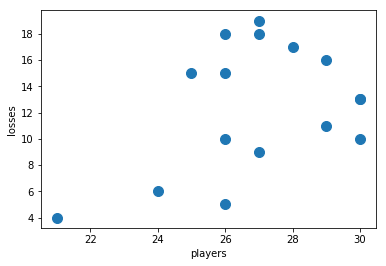

In [10]:
panda_teams.plot.scatter(x='players',y='losses',s=100)

In [11]:
del panda_teams['name']
panda_teams

,losses,players
0,13,30
1,4,21
2,17,28
3,13,30
4,10,26
5,10,30
6,18,26
7,5,26
8,11,29
9,18,27


Нормализуем данные

In [12]:
whitened = whiten(panda_teams.as_matrix())
whitened

array([[  2.79578984,  12.7244432 ],
       [  0.86024303,   8.90711024],
       [  3.65603287,  11.87614698],
       [  2.79578984,  12.7244432 ],
       [  2.15060757,  11.02785077],
       [  2.15060757,  12.7244432 ],
       [  3.87109363,  11.02785077],
       [  1.07530378,  11.02785077],
       [  2.36566833,  12.30029509],
       [  3.87109363,  11.45199888],
       [  3.22591135,  11.02785077],
       [  3.22591135,  10.60370266],
       [  1.29036454,  10.17955456],
       [  1.93554681,  11.45199888],
       [  3.44097211,  12.30029509],
       [  4.08615438,  11.45199888]])

Разбиваем на 3 кластера

In [13]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[  3.6253099 ,  11.39140629],
        [  1.46241315,  10.51887304],
        [  2.52696389,  12.61840617]]),
 array([2, 1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0]))

In [14]:
colors_map = {0: 'r', 1: 'g', 2: 'b'}
colors = [colors_map[c] for c in cluster_map]

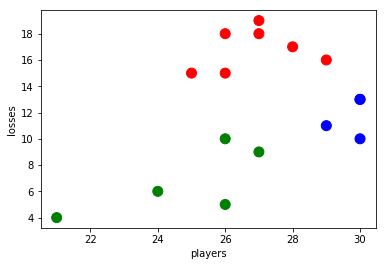

In [15]:
panda_teams.plot.scatter(x='players', y='losses', c=colors, s=100)

Разбиваем на 5 кластеров

In [16]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[  2.52696389,  12.61840617],
        [  3.78506932,  11.62165812],
        [  1.72048606,  11.16923347],
        [  1.07530378,   9.5433324 ],
        [  3.22591135,  10.81577672]]),
 array([0, 3, 1, 0, 2, 0, 1, 2, 0, 1, 4, 4, 3, 2, 1, 1]))

In [18]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

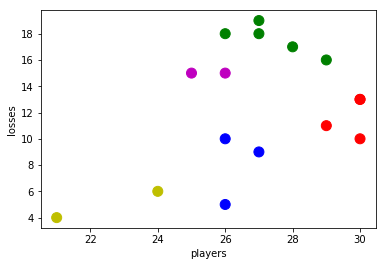

In [19]:
panda_teams.plot.scatter(x='players', y='losses', c=colors, s=100)